# Introduction
This project analyzes sentiments from stock news, focusing on Indian stocks (NSE/BSE) using API Ingestion (Groww API) and FinBERT (finance sentiment analysis model). <br>
My GitHub:
[Indian Stock News Sentiment Analysis](https://github.com/RelativelyBurberry/Indian-Stock-News-Sentiment-Analysis)



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nrc-emoticon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt


# Getting the DataSet using WebScraping
## - Beautiful Soup for Static HTML

In [2]:
import pandas as pd
import numpy as np
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

api_df = pd.DataFrame()
bs4_df = pd.DataFrame()

#Static (BS4)

groww_url = "https://groww.in/market-news/stocks"
req = Request(url = groww_url, headers = {'user-agent':'app'})  #Request to Server
response = urlopen(req)
print(response)
html = BeautifulSoup(response,'html') #Static HTML data

#Structure of a news card in Groww website
'''
<a class="contentPrimary truncate stockNewsCard_companyName__QGEnc" 
href="https://groww.in/stocks/rolcon-engineering-company-ltd">Rolcon Engineering</a>
<span class="bodyBase contentPrimary">0.00%</span></div><div class="stockNewsCard_newsCardDescription__ltQ2j">
<span class="bodyBase undefined" style="display:-webkit-box;-webkit-line-clamp:2;-webkit-box-orient:vertical;overflow:hidden">
Rolcon Engineering disclosed insider share sales by promoter director group.
700 shares gifted, 14,015 shares sold off-market, as per SEBI norms. Source: ScoutQuest</span></div></div
'''

#Manipulation of Data
import re
news_cards = html.find_all(
        'a',
        class_ = re.compile(r"borderPrimary contentPrimary flex flex-column vspace-between stockNewsCard_container")
    )

parsed_data = [] #name,time,headline
for card in news_cards:
    name = card.find(
        "a",
        class_=re.compile(r"stockNewsCard_companyName")
    ).text

    time = card.find(
        'div',
        class_=re.compile(r"contentSecondary")
    ).text

    headline = card.find(
        'span',
        class_ = re.compile(r"\bbodyBase undefined\b")
    ).text.split('Source')[0].replace('\n',' ').strip()
    parsed_data.append([name,time,headline])

bs4_df = pd.DataFrame(parsed_data,columns = ['ticker','time','title'])
print(bs4_df)

                     ticker      time  \
0       Sadbhav Engineering    3 mins   
1         Godrej Properties   20 mins   
2                       SBI   20 mins   
3     Samvardhana Motherson   23 mins   
4                  MRP Agro   37 mins   
5                      RECL   1 hour    
6                      IOCL   2 hours   
7        Pearl Global Inds.   2 hours   
8           Jonjua Overseas   3 hours   
9                 NLC India   3 hours   
10            Bajaj Finance   3 hours   
11         Refex Industries   4 hours   
12       Varroc Engineering   5 hours   
13     Religare Enterprises   5 hours   
14                    Wipro   5 hours   
15       HDFC Asset Mgmt Co   6 hours   
16  Reliance Communications   6 hours   
17          Dr Lal PathLabs   6 hours   
18      Refex Renewbl&Infra   7 hours   
19        NTPC Green Energy   7 hours   
20         Eternal (Zomato)   9 hours   
21             JM Financial  15 hours   
22          Dr Reddy's Labs  15 hours   
23             M

However, this is not ideal, as we cannot extract the NSE/BSE ticker from the HTML page, and there is too little data with lots of variation, so there is no point of sentiment analysis. <br> 
Therefore we now go for API Ingestion

## - API Ingestion  (Groww API) for Dynamic HTML Pages
**Steps to get API Params**
- Ctrl+Shift+I (Developer Tools)
- Network Tab
- Fetch/XHR
- Click on a request object
- Headers
- Request URL = API URL and User-Agent = user-agent
- Payload = Body of the Request
- Response = Server's Response to the request -> **The actual data we need**

My GitHub has the exact tutorial with images
[Indian Stock News Sentiment Analysis](https://github.com/RelativelyBurberry/Indian-Stock-News-Sentiment-Analysis)

In [3]:
#Dynamic HTML 
import pandas as pd
import numpy as np
import requests
api_url="https://groww.in/v2/api/feed/public?page="
add = "&publisherId=stocknewssummary&size=50"
page=0
print(api_url+str(page)+add)

nse_parsed_data = []
bse_parsed_data = []  #separate dataset for stocks only in bse

#Since Groww's and most websites backends are in javascript, we have to use another module called requests to handle that,
#mainly using the 'get' function

#Typical Groww Item in Json
'''
{ 
"name": "406824_Power Grid Corporation Of India Ltd.-1-VariationA", 
"postId": "406824_Power Grid Corporation Of India Ltd.-1-VariationA", 
"category": null, 
"publisher": "Stock News Summary", 
"publisherId": "stocknewssummary", 
"publishedAt": "2025-12-11T10:57:26", ⬅️
"expireAt": "2025-12-16T10:57:26", 
"campaignType": "GENERIC", 
"data": { 
        "cta": [ { 
                "type": "STOCK", 
                "ctaText": "Power Grid Corp", ↩️
                "ctaUrl": "https://groww.in/stocks/power-grid-corporation-of-india-ltd", 
                "logoUrl": "https://assets-netstorage.groww.in/stock-assets/logos2/POWERGRID.webp", 
                "meta": { 
                    "bseScriptCode": "532898", ↩️
                    "nseScriptCode": "POWERGRID" } ⬅️
                    } ], 
"title": "Power Grid to Merge 13 Subsidiaries into 2 on Dec 20", ⬅️
"body": "Power Grid Corp to discuss merging 13 subsidiaries into 2 entities on Dec 20.\n\nSource: Livesquawk", ⬅️
"media": [], 
"reactions": [ { 
        "type": "LIKE", 
        "count": 0, 
        "active": true } ] 
        } 
},
'''

while(1):
    r = requests.get(api_url+str(page), 
                     headers={"user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/143.0.0.0 Safari/537.36"}
                    ) 
    #url + page no. being loaded, header will have the user-agent from devtools
    data = r.json()  #the data will be a json file
    if not data.get('feed'):  #when feed is empty, i.e. the data is empty
        break
    page+=1 #next page

    for item in data['feed']: 
        title = item.get("data",{}).get("title") +" "+ item.get("data",{}).get("body").split("Source")[0].replace('\n',"").strip() 
        date = item.get("publishedAt").split('T')[0]
        
        if item.get("data", {}).get("cta", [])!= None:  #gives this error sometimes so 
            name = item.get("data", {}).get("cta", [])[0].get("ctaText")
            nse = item.get("data", {}).get("cta", [])[0].get("meta",{}).get("nseScriptCode")
            bse = item.get("data", {}).get("cta", [])[0].get("meta",{}).get("bseScriptCode")
            if nse:  #use nse if nse exists
                ticker = nse
                nse_parsed_data.append([ticker,name,date,title])
            elif bse: #otherwise bse
                ticker = bse
                bse_parsed_data.append([ticker,name,date,title])
       
        #print(date)
        #print(ticker)
        #print(title)
        

nse_df = pd.DataFrame(nse_parsed_data, columns = ['ticker','name','date','title'])
print(nse_df,nse_df.isna().sum())
bse_df = pd.DataFrame(bse_parsed_data, columns = ['ticker','name','date','title'])
print(bse_df)

https://groww.in/v2/api/feed/public?page=0&publisherId=stocknewssummary&size=50
         ticker                   name        date  \
0       SADBHAV    Sadbhav Engineering  2025-12-14   
1    GODREJPROP      Godrej Properties  2025-12-14   
2          SBIN                    SBI  2025-12-14   
3     MOTHERSON  Samvardhana Motherson  2025-12-14   
4        RECLTD                   RECL  2025-12-14   
..          ...                    ...         ...   
829    SPLPETRO      Supreme Petrochem  2025-12-09   
830     UGROCAP           Ugro Capital  2025-12-09   
831   KALPATARU              Kalpataru  2025-12-09   
832      ANURAS         Anupam Rasayan  2025-12-09   
833      CRISIL                 CRISIL  2025-12-09   

                                                 title  
0    Sadbhav Engg Board to Discuss ₹1,000 Cr NCDs o...  
1    Godrej Sells ₹2,600 Cr Homes in Hyderabad, Eye...  
2    Rupee Depreciation May Boost Inflation; GST Re...  
3    Samvardhana Motherson Subsidiary Faces

# Sentiment Analysis Using FinBERT

In [4]:
#!pip uninstall protobuf -y
!pip install protobuf==3.20.3

#for version mismatches in finBERT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

## NSE Analysis

In [5]:
from transformers import pipeline

finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert")

nse_test = nse_df.copy()
bse_test = bse_df.copy()


texts = nse_test['title'].fillna('').str[:512].tolist()
res = finbert(texts, batch_size=16)

nse_test['sentiment'] = [r['label'] for r in res]
nse_test['confidence'] = [r['score'] for r in res]


2025-12-14 13:40:22.821532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765719623.139294      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765719623.223437      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


## BSE Analysis

In [6]:

texts = bse_test['title'].fillna('').str[:512].tolist()
res = finbert(texts, batch_size=16)

bse_test['sentiment'] = [r['label'] for r in res]
bse_test['confidence'] = [r['score'] for r in res]

In [7]:
print(nse_test)
print(bse_test)

         ticker                   name        date  \
0       SADBHAV    Sadbhav Engineering  2025-12-14   
1    GODREJPROP      Godrej Properties  2025-12-14   
2          SBIN                    SBI  2025-12-14   
3     MOTHERSON  Samvardhana Motherson  2025-12-14   
4        RECLTD                   RECL  2025-12-14   
..          ...                    ...         ...   
829    SPLPETRO      Supreme Petrochem  2025-12-09   
830     UGROCAP           Ugro Capital  2025-12-09   
831   KALPATARU              Kalpataru  2025-12-09   
832      ANURAS         Anupam Rasayan  2025-12-09   
833      CRISIL                 CRISIL  2025-12-09   

                                                 title sentiment  confidence  
0    Sadbhav Engg Board to Discuss ₹1,000 Cr NCDs o...   neutral    0.908321  
1    Godrej Sells ₹2,600 Cr Homes in Hyderabad, Eye...  positive    0.818544  
2    Rupee Depreciation May Boost Inflation; GST Re...  positive    0.945328  
3    Samvardhana Motherson Subsidia

# Visualization

FinBERT gives {"sentiment" : "score"} format while NLTK VADER returns a {"neg","nue","pos","compound"} format. <br>
To replicate compound, we did sentiment mapping, and save the VADER-ified FinBERT as nse_test2 and bse_test2

In [8]:
nse_test2 = nse_test.copy()

sentiment_map = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

nse_test2['compound'] = nse_test2['sentiment'].map(sentiment_map) * nse_test2['confidence']


bse_test2 = bse_test.copy()

sentiment_map = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

bse_test2['compound'] = bse_test2['sentiment'].map(sentiment_map) * bse_test2['confidence']

print(nse_test2)
print(bse_test2)

         ticker                   name        date  \
0       SADBHAV    Sadbhav Engineering  2025-12-14   
1    GODREJPROP      Godrej Properties  2025-12-14   
2          SBIN                    SBI  2025-12-14   
3     MOTHERSON  Samvardhana Motherson  2025-12-14   
4        RECLTD                   RECL  2025-12-14   
..          ...                    ...         ...   
829    SPLPETRO      Supreme Petrochem  2025-12-09   
830     UGROCAP           Ugro Capital  2025-12-09   
831   KALPATARU              Kalpataru  2025-12-09   
832      ANURAS         Anupam Rasayan  2025-12-09   
833      CRISIL                 CRISIL  2025-12-09   

                                                 title sentiment  confidence  \
0    Sadbhav Engg Board to Discuss ₹1,000 Cr NCDs o...   neutral    0.908321   
1    Godrej Sells ₹2,600 Cr Homes in Hyderabad, Eye...  positive    0.818544   
2    Rupee Depreciation May Boost Inflation; GST Re...  positive    0.945328   
3    Samvardhana Motherson Subs

## Market Sentiment Pie Chart

In [9]:
df1 = nse_test2.copy()
df2 = bse_test2.copy()
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

sentiment_counts = df1['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']

fig = px.pie(
    sentiment_counts,
    names='sentiment',
    values='count',
    title='FinBERT Sentiment Distribution NSE',
    hole=0.4  # donut chart (looks cleaner)
)

fig.update_traces(
    textposition='inside',
    textinfo='percent+label'
)

fig.show(renderer="iframe")

print(sentiment_counts)


  sentiment  count
0   neutral    346
1  positive    312
2  negative    176


## Percentage-Wise Stacked Bar Graph

In [10]:
# %-age wise stacked bar graph

top10 = (
    df1['ticker']
    .value_counts()
    .head(10)
    .index
)

sentiment_pct = (
    df1[df1['ticker'].isin(top10)]
    .groupby(['ticker', 'sentiment'])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .droplevel(0)
    .unstack(fill_value=0)
)

sentiment_pct_plot = sentiment_pct.reset_index()
print(sentiment_pct)

sentiment   negative    neutral    positive
ticker                                     
GRASIM     20.000000  60.000000   20.000000
INDIGO     61.538462  15.384615   23.076923
IOC        44.444444  22.222222   33.333333
JSWENERGY  33.333333  44.444444   22.222222
LT          0.000000   0.000000  100.000000
SBIN       37.500000  37.500000   25.000000
SIEMENS    50.000000  16.666667   33.333333
TATAPOWER   0.000000  33.333333   66.666667
TATASTEEL  21.428571   7.142857   71.428571
TCS        12.500000  37.500000   50.000000


### Plotly

In [11]:
sentiment_pct_plot_px = sentiment_pct_plot.reset_index()

fig = px.bar(
    sentiment_pct_plot_px,
    x='ticker',
    y=['positive', 'neutral', 'negative'],
    title="FinBERT Sentiment Distribution (%) — Top 10 NSE Stocks",
    color_discrete_map={
        "positive": "#4C9F70",  # chic green
        "neutral":  "#DDCC77",  # muted yellow
        "negative": "#C44E52"   # soft red
    },
    labels={
        'value': 'Percentage of Articles',
        'ticker': 'Stock Ticker'
    },
    text_auto=".0f"
)

fig.update_layout(
    barmode='stack',
    yaxis=dict(range=[0, 100]),
    template='plotly_white',
    legend_title_text='Sentiment'
)

fig.show(renderer="iframe")

### Matplotlib

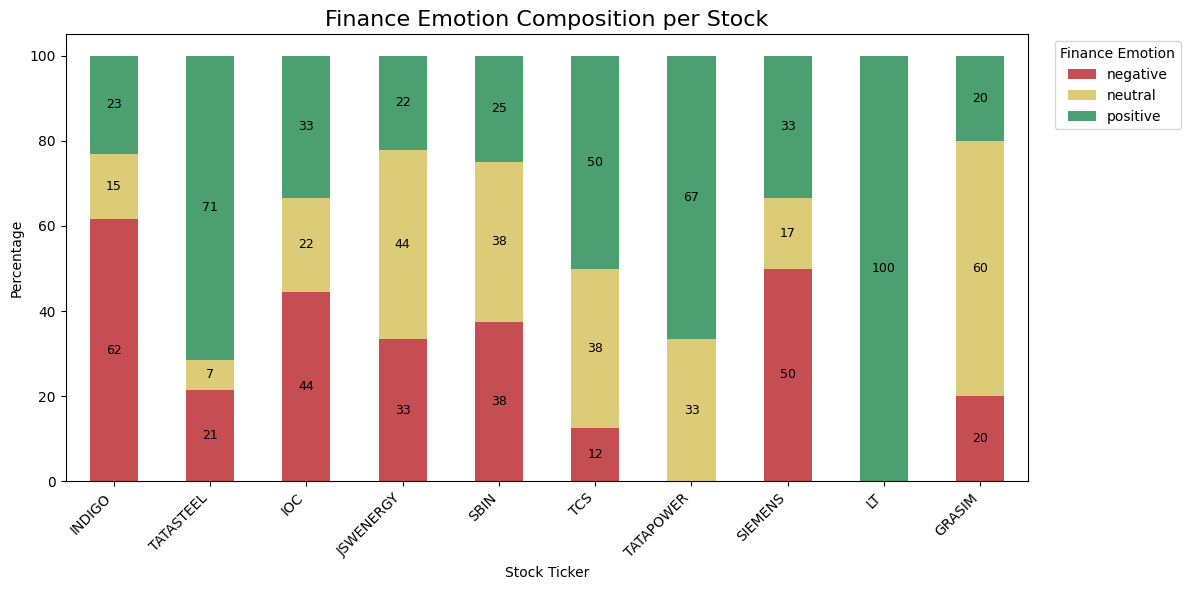

In [12]:
import matplotlib.pyplot as plt

sentiment_pct_plot = sentiment_pct.reindex(top10)

colors = {
    "negative": "#C44E52",   # soft red
    "neutral":  "#DDCC77",   # warm muted yellow
    "positive": "#4C9F70"    # calm green
}
sentiment_pct_plot.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    color=[colors[c] for c in ["negative", "neutral", "positive"]]
)

plt.title("Finance Emotion Composition per Stock", fontsize=16)
plt.xlabel("Stock Ticker")
plt.ylabel("Percentage")
plt.legend(title="Finance Emotion", bbox_to_anchor=(1.02, 1), loc="upper left")
ax = plt.gca()
ax.set_xticks(np.arange(len(top10)))
ax.set_xticklabels(top10, rotation=45, ha="right")
#Add percentage labels inside bars
for container in ax.containers:
    labels = [
        f"{v:.0f}" if v > 0 else ""
        for v in container.datavalues
    ]
    ax.bar_label(
        container,
        labels=labels,
        label_type="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()

## Sentiment Over Time
## Normalized Sentiment 

Proper Date: 
 
     ticker                 name        date  \
0      SBIN                  SBI  2025-12-14   
1       IOC                 IOCL  2025-12-14   
2      SBIN                  SBI  2025-12-13   
3      SBIN                  SBI  2025-12-13   
4  RELIANCE  Reliance Industries  2025-12-13   

                                               title sentiment  confidence  \
0  Rupee Depreciation May Boost Inflation; GST Re...  positive    0.945328   
1  Panel Urges Diversification in Oil Imports Ami...  positive    0.852012   
2  SBI, PPFAS Hold ₹10,000 Cr Cash in Nov as Mutu...  negative    0.971357   
3  SBI Cuts MCLR by 5 bps, Revises Deposit Rates ...  negative    0.866536   
4  Reliance Retail Preps for 2028 IPO Reliance Re...   neutral    0.616862   

   compound  
0  0.945328  
1  0.852012  
2 -0.971357  
3 -0.866536  
4  0.000000  
 
Mean_Df Series
 
ticker     date      
GRASIM     2025-12-09    0.312828
           2025-12-10   -0.915133
           2025-12-12    0.000000

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



 
this is mean and stdev of each ticker :         ticker      mean       std
0      GRASIM  0.004670  0.655384
1         HCC  0.168912  0.909596
2      INDIGO -0.383808  0.755829
3         IOC -0.131163  0.819947
4   JSWENERGY -0.144371  0.703413
5          LT  0.889820  0.071078
6    RELIANCE  0.676771  0.396792
7        SBIN -0.105150  0.757039
8     SIEMENS -0.184011  0.900042
9   TATAPOWER  0.538949  0.433869
10  TATASTEEL  0.459962  0.720757
11        TCS  0.312829  0.645663
 
       ticker      mean       std    zscore   std_raw
0      GRASIM  0.004670  0.655384 -0.429002  0.655384
1         HCC  0.168912  0.909596 -0.016023  0.909596
2      INDIGO -0.383808  0.755829 -1.405813  0.755829
3         IOC -0.131163  0.819947 -0.770547  0.819947
4   JSWENERGY -0.144371  0.703413 -0.803758  0.703413
5          LT  0.889820  0.071078  1.796669  0.071078
6    RELIANCE  0.676771  0.396792  1.260967  0.396792
7        SBIN -0.105150  0.757039 -0.705139  0.757039
8     SIEMENS -0.184011  0.

<Figure size 1500x1500 with 0 Axes>

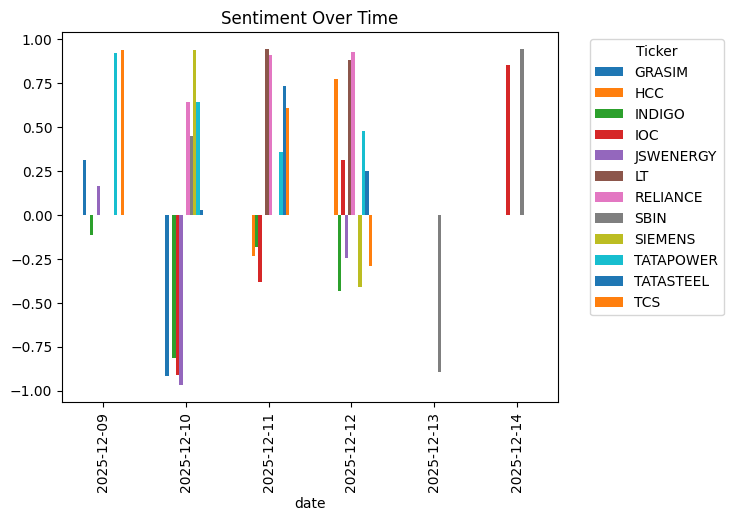

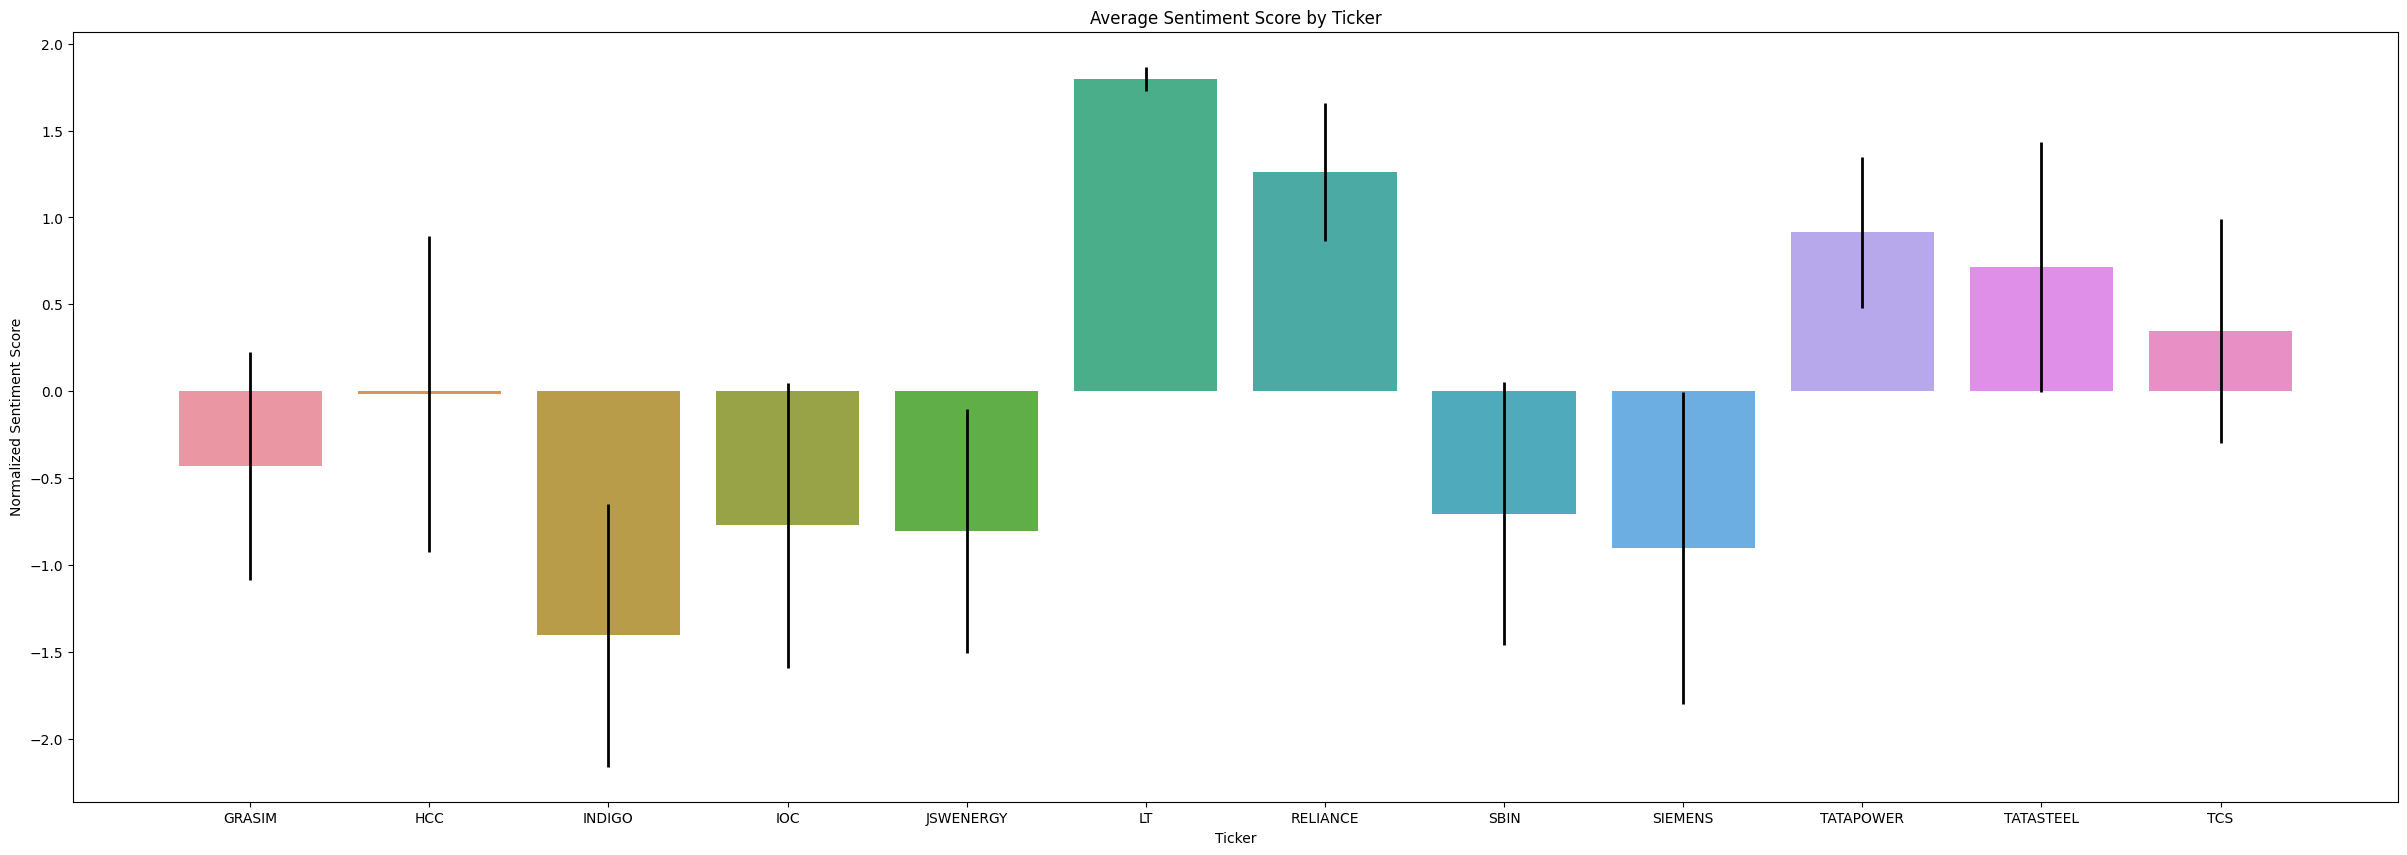

In [13]:
top_10_tickers = df1['ticker'].value_counts().head(12).index
#print(top_10_tickers)

df_top10 = df1[df1['ticker'].isin(top_10_tickers)].reset_index(drop=True)

#print(df_top10)

import matplotlib.pyplot as plt
plt.close('all')
#-------------------------------------------------------------------------------------
#Sentiment Over Time Graph
def sentiment_over_time(df):    #make it a function for later use
    plt.figure(figsize=(15,15))
    
    # ensure compound is numeric
    df['compound'] = pd.to_numeric(df['compound'], errors='coerce') #coerce means if value cant be converted turn it into NaN instead of throwing error
    
    # ensure date is a proper date
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date 
        #this line converts df date column to a datetime object column , makes invalid data = NaN,
            #dt is a datetime accessor, and dt.date converts pandas timestamp (date + time) to python date (only date)
    print("Proper Date: ")
    print(" ")
    print(df.head())
    print(" ")
    # compute mean sentiment per ticker per date
    mean_df = df.groupby(['ticker','date'])['compound'].mean()
        #groups ticker and date,  then selects only compound column and computes mean for every group of ticker+date
        #this is not a dataframe, this is a series with multiindex
    print("Mean_Df Series")
    print(" ")
    print(mean_df)
    print(" ")
    mean_df = mean_df.unstack()
    #acts on last index level and makes it a column, and ticker is the rows, with value = mean_compound
    #now its a dataframe again
    print("Mean_df DataFrame ")
    print(" ")
    print(mean_df.head())
    print(" ")
    mean_df = mean_df.transpose()
    #we need date on x axis, so transpose
    
    
    mean_df.plot(kind="bar")
    plt.title("Sentiment Over Time")
    plt.legend(
    title="Ticker",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

    plt.show

sentiment_over_time(df_top10)
#-------------------------------------------------------------------------------------

#Normalized Sentiment Graph
import seaborn as sns
#Z-score = (Value - Mean)  /  Stdev
#https://www.geeksforgeeks.org/data-science/z-score-in-statistics/

def normalized_graph(df):
    # 1. Compute mean + std per ticker
    stats = df.groupby("ticker")["compound"].agg(['mean','std']).reset_index()
    #groups, compound, mean stdev and reset_index() converts it back to dataframe
    print(" ")
    print("this is mean and stdev of each ticker : ", stats)
    print(" ")
    
    # 2. Compute global mean and std for Z-score formula
    global_mean = stats['mean'].mean()     
    global_std  = stats['mean'].std() if stats['mean'].std() != 0 else 1.0   #else 1.0 in case all tickers means are the same, in which case it would divide by 0 => make it 1.0
    
    # 3. Z-score normalize the MEAN ONLY
    stats['zscore'] = (stats['mean'] - global_mean) / global_std
    
    # 4. Use RAW STD for error bars (DO NOT normalize std)
    stats['std_raw'] = stats['std']
    
    # Create a bar chart to show the average sentiment score for each ticker
    
    print(stats)
    plt.figure(figsize=(30, 10))
    sns.barplot(x='ticker', y='zscore', data=stats)
    plt.title('Average Sentiment Score by Ticker')
    plt.xlabel('Ticker')
    plt.ylabel('Normalized Sentiment Score')
    plt.errorbar(
        x=stats['ticker'],
        y=stats['zscore'],
        yerr=stats['std_raw'],
        fmt='none',
        ecolor='black',
        elinewidth=2,       # thickness of the black lines
        capsize=0         # length of the top/bottom caps
    )
    plt.show()
normalized_graph(df_top10)

## HeatMap per Stock per Date

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



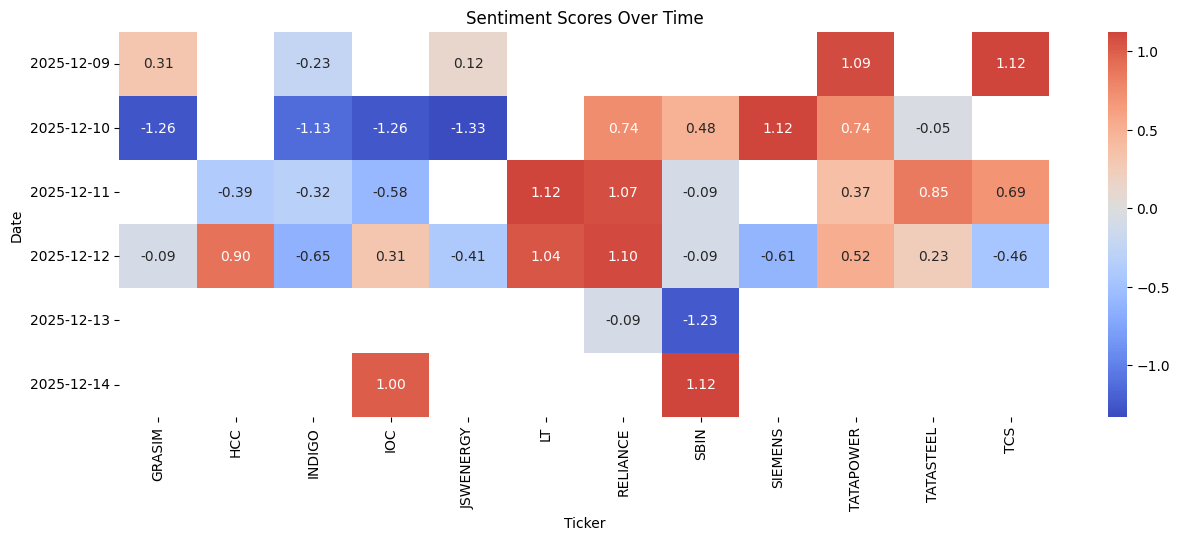

In [14]:
import seaborn as sns
def heatmap(df):
    # 1. Normalize the compound values globally
    df['normalized_score'] = (df['compound'] - df['compound'].mean()) / df['compound'].std()
    
    # 2. Compute mean normalized score per date and ticker
    daily = df.groupby(['date','ticker'], as_index=False)['normalized_score'].mean()
    # 3. Pivot into heatmap matrix
    pivot_sentiment_df = daily.pivot(index='date', columns='ticker', values='normalized_score')
    
    plt.figure(figsize=(15, 5))
    sns.heatmap(pivot_sentiment_df, cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Sentiment Scores Over Time')
    plt.xlabel('Ticker')
    plt.ylabel('Date')
    plt.show()
heatmap(df_top10)

## TreeMap NSE

In [15]:
import plotly.express as px
import pandas as pd
##-----------------------------------------------------------------------------------------------
#Treemap
import plotly.io as pio
pio.renderers.default = 'iframe'

def treemap_of_normalized_score(df):
    stats = df.groupby("ticker")["compound"].agg(['mean','std']).reset_index()
    global_mean = stats['mean'].mean()     
    global_std  = stats['mean'].std() if stats['mean'].std() != 0 else 1.0   #else 1.0 in case all tickers means are the same, in which case it would divide by 0 => make it 1.0
    
    #Z-score normalize the MEAN ONLY
    stats['zscore'] = (stats['mean'] - global_mean) / global_std
    
    #treemap doesn't take negative values so turn negative into positive but preserving hierarchy
    min_z = stats['zscore'].min()
    stats['size_plot'] = stats['zscore'] - min_z + 1
    
    #make a new dataframe with only the values we need
    plot_df = pd.DataFrame({ 
        'ticker' : stats['ticker'],
        'size_plot' : stats['size_plot'],
        'zscore' :  stats['zscore']          #for label
    })
    
    
    print(plot_df.shape)
    print(plot_df.head())
    
    
    #we used plotly here because doing it in matplotlib will be a pain in the ass
    
    fig = px.treemap(
        plot_df,
        path=[px.Constant("Stocks"), 'ticker'],
        values='size_plot',
    )
    
    fig.update_traces(customdata=plot_df['zscore'])
    fig.update_traces(
        texttemplate="%{label}<br>(%{customdata:.2f})",
        textposition="middle center"
    )
    
    fig.show(renderer="iframe")

treemap_of_normalized_score(df_top10)

(12, 3)
      ticker  size_plot    zscore
0     GRASIM   1.976811 -0.429002
1        HCC   2.389790 -0.016023
2     INDIGO   1.000000 -1.405813
3        IOC   1.635265 -0.770547
4  JSWENERGY   1.602055 -0.803758


## TreeMap BSE

In [16]:
import plotly.express as px
import pandas as pd
top_10_tickers_bse = df2['name'].value_counts().head(12).index
#print(top_10_tickers)

df_top10_bse = df2[df2['name'].isin(top_10_tickers_bse)].reset_index(drop=True)
##-----------------------------------------------------------------------------------------------
#Treemap
import plotly.io as pio
pio.renderers.default = 'iframe'

def treemap_of_normalized_score(df):
    stats = df.groupby("name")["compound"].agg(['mean','std']).reset_index()
    print(stats)
    global_mean = stats['mean'].mean()     
    global_std  = stats['mean'].std() if stats['mean'].std() != 0 else 1.0   #else 1.0 in case all tickers means are the same, in which case it would divide by 0 => make it 1.0
    
    #Z-score normalize the MEAN ONLY
    stats['zscore'] = (stats['mean'] - global_mean) / global_std
    
    #treemap doesn't take negative values so turn negative into positive but preserving hierarchy
    min_z = stats['zscore'].min()
    stats['size_plot'] = stats['zscore'] - min_z + 1
    
    #make a new dataframe with only the values we need
    plot_df = pd.DataFrame({ 
        'ticker' : stats['name'],
        'size_plot' : stats['size_plot'],
        'zscore' :  stats['zscore']          #for label
    })
    
    
    print(plot_df.shape)
    print(plot_df.head())
    
    
    #we used plotly here because doing it in matplotlib will be a pain in the ass
    
    fig = px.treemap(
        plot_df,
        path=[px.Constant("Stocks"), 'ticker'],
        values='size_plot',
    )
    
    fig.update_traces(customdata=plot_df['zscore'])
    fig.update_traces(
        texttemplate="%{label}<br>(%{customdata:.2f})",
        textposition="middle center"
    )
    
    fig.show(renderer="iframe")

treemap_of_normalized_score(df_top10_bse)

                    name      mean       std
0                Atishay  0.359282  0.508102
1      Indrayani Biotech  0.042263  1.291358
2           MRC Agrotech  0.000000  0.000000
3               MRP Agro  0.441703  0.624663
4                Marsons  0.367534  0.321284
5       Norris Medicines  0.000000  0.000000
6      Onix Solar Energy  0.000000  0.000000
7    Oriental Rail Infra  0.477551  0.675360
8        Regency Fincorp  0.472146  0.667716
9              Rose Merc  0.473752  0.669986
10  Three M Paper Boards  0.000000  0.000000
11   Unifinz Capital Ind  0.431633  0.610421
(12, 3)
              ticker  size_plot    zscore
0            Atishay   2.622343  0.468681
1  Indrayani Biotech   1.190838 -0.962824
2       MRC Agrotech   1.000000 -1.153662
3           MRP Agro   2.994516  0.840854
4            Marsons   2.659604  0.505942


## Emotion Analysis Per Stock 

Using NRC Emotion Lexicon and mapping words to different emotions, and then just counting the number of times those emotions show up.

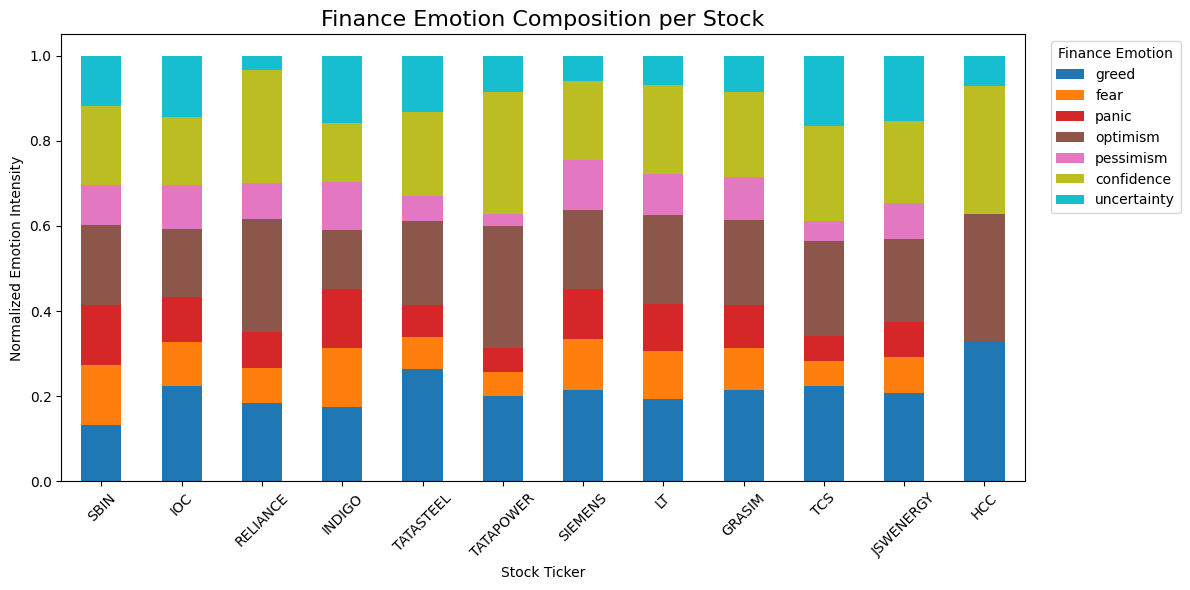

In [17]:
import pandas as pd
import re
import matplotlib.pyplot as plt

lexicon_path = "/kaggle/input/nrc-emoticon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

emotion_map = {}

with open(lexicon_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) != 3:
            continue
        word, emotion, value = parts
        if int(value) == 1:
            emotion_map.setdefault(word, []).append(emotion)


FINANCE_WORDS = {
    # GREED / RISK-ON
    "greed": ["positive", "anticipation"],
    "rally": ["positive", "anticipation"],
    "surge": ["positive"],
    "boom": ["positive"],
    "bullish": ["positive", "trust"],
    "outperform": ["positive"],
    "upgrade": ["positive", "trust"],
    "record": ["positive"],

    # FEAR / RISK-OFF
    "crash": ["negative", "fear"],
    "panic": ["negative", "fear"],
    "selloff": ["negative", "fear"],
    "slump": ["negative"],
    "collapse": ["negative", "fear"],
    "downgrade": ["negative", "sadness"],
    "default": ["negative", "fear"],
    "bankrupt": ["negative", "fear"],

    # UNCERTAINTY
    "volatility": ["anticipation", "fear"],
    "uncertain": ["anticipation"],
    "probe": ["fear"],
    "investigation": ["fear"],
    "scrutiny": ["fear"],
    "regulatory": ["anticipation"],

    # CONFIDENCE / STABILITY
    "stable": ["trust"],
    "resilient": ["trust", "positive"],
    "strong": ["trust", "positive"],
    "guidance": ["anticipation"],

    # MACRO
    "inflation": ["fear"],
    "recession": ["fear", "negative"],
    "rate-cut": ["positive", "anticipation"],
    "rate-hike": ["negative", "fear"]
}

# Merge finance words into NRC lexicon
for word, emotions in FINANCE_WORDS.items():
    emotion_map.setdefault(word, [])
    for emo in emotions:
        if emo not in emotion_map[word]:
            emotion_map[word].append(emo)


FINANCE_EMOTIONS = [
    "greed",
    "fear",
    "panic",
    "optimism",
    "pessimism",
    "confidence",
    "uncertainty"
]

FINANCE_EMOTION_MAP = {
    "greed": ["positive", "anticipation"],
    "fear": ["fear", "negative"],
    "panic": ["fear", "sadness", "negative"],
    "optimism": ["positive", "trust"],
    "pessimism": ["negative", "sadness"],
    "confidence": ["trust", "positive"],
    "uncertainty": ["anticipation", "fear"]
}


def finance_emotion_distribution(df, emotion_map):
    df = df.copy()
    df["title"] = df["title"].astype(str)

    stock_scores = {}

    for ticker in df["ticker"].unique():
        counts = {e: 0 for e in FINANCE_EMOTIONS}
        total_hits = 0

        titles = df[df["ticker"] == ticker]["title"]

        for title in titles:
            words = re.findall(r"[a-zA-Z']+", title.lower())
            for w in words:
                if w in emotion_map:
                    for fin_emo, base_emos in FINANCE_EMOTION_MAP.items():
                        if any(be in emotion_map[w] for be in base_emos):
                            counts[fin_emo] += 1
                            total_hits += 1

        if total_hits > 0:
            counts = {k: v / total_hits for k, v in counts.items()}
            stock_scores[ticker] = counts

    return pd.DataFrame(stock_scores).T


finance_df = finance_emotion_distribution(df_top10, emotion_map)

finance_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    colormap="tab10"
)

plt.title("Finance Emotion Composition per Stock", fontsize=16)
plt.xlabel("Stock Ticker")
plt.ylabel("Normalized Emotion Intensity")
plt.legend(title="Finance Emotion", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Radar Chart

In [18]:
import plotly.graph_objects as go

def plot_finance_radar_plotly(finance_df, ticker):
    # Extract values
    values = finance_df.loc[ticker].values.tolist()
    labels = finance_df.columns.tolist()

    # Close the loop
    values += [values[0]]
    labels += [labels[0]]

    fig = go.Figure()

    fig.add_trace(
        go.Scatterpolar(
            r=values,
            theta=labels,
            fill='toself',
            name=ticker,
            line=dict(width=3),
            opacity=0.75
        )
    )

    fig.update_layout(
        title=f"Finance Emotion Profile — {ticker}",
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, max(values) * 1.2]
            )
        ),
        showlegend=False,
        template="plotly_white"
    )

    fig.show(renderer="iframe")

plot_finance_radar_plotly(finance_df, "SBIN")


## Word Cloud

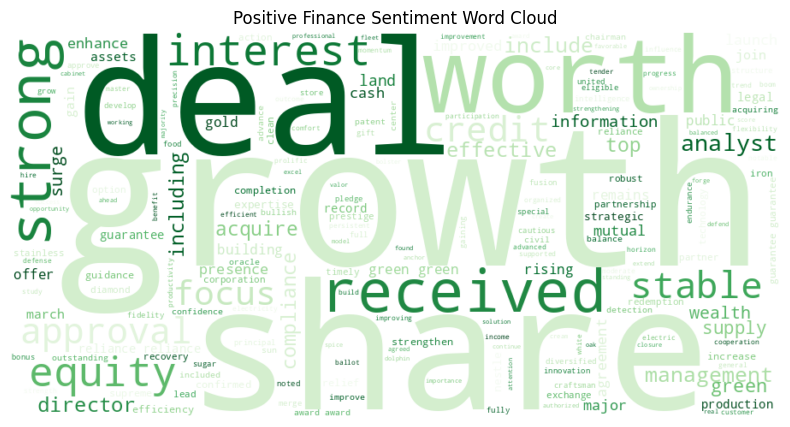

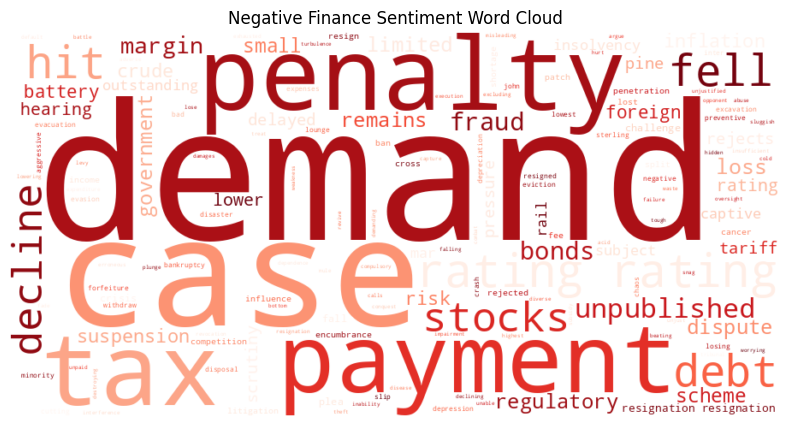

In [19]:
import re

positive_words = []
negative_words = []

for text in df1['title'].astype(str):
    words = re.findall(r"[a-zA-Z']+", text.lower())

    for w in words:
        if w in emotion_map:
            emos = emotion_map[w]
            if 'positive' in emos:
                positive_words.append(w)
            if 'negative' in emos:
                negative_words.append(w)

positive_text = " ".join(positive_words)
negative_text = " ".join(negative_words)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc_pos = WordCloud(
    width=900,
    height=450,
    background_color='white',
    colormap='Greens',
    max_words=200
).generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Finance Sentiment Word Cloud")
plt.show()

wc_neg = WordCloud(
    width=900,
    height=450,
    background_color='white',
    colormap='Reds',
    max_words=200
).generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Finance Sentiment Word Cloud")
plt.show()
